In [1]:
# pip install contractions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
#word stemmer class
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /Users/su/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data preprocessing

In [3]:
import re
def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0]== '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]',' ',  tweets)
    tweets = tweets.lower()
    tweets = [lemma.lemmatize(word) for word in tweets]
    tweets = "".join(tweets)
    return tweets

In [ ]:
import contractions
from nltk.corpus import stopwords
def preprocess_tweets(tweets, punctuations=False):
    """ Removes account tags (@user) and all non-alphanumeric characters except whitespace.
    Args:
        tweets (pd.series): Pandas series object containing tweets.
    Returns:
        df_series (pd.series): Pandas series object containing preprocessed tweets. 
    """
    
    # Expand contractions (Eg: can't --> cannot)
    for i in range(len(tweets)):
        tweets.iloc[i] = contractions.fix(tweets.iloc[i])
    
    # Removes '@user' tags
    tweets = tweets.str.replace("@user", "", regex=False)
    
    # Removes '&amp' tags
    tweets = tweets.str.replace("&amp", "")
    
    # Removes non alphanumeric characters
    if not punctuations: 
        tweets = tweets.str.replace("[^a-zA-Z0-9]", " ")
    
    # Remove stop words and lemmatize tweets
    stop_words = set(stopwords.words("english"))
    for i in range(len(tweets)):
        tweets.iloc[i] = ' '.join([lemma.lemmatize(word) for word in tweets.iloc[i].split() 
                                  if not word.lower() in stop_words])
    
    return tweets

In [5]:
def data_process(df, save=False, fn='None'):
    df['hashtag'] = df.tweet.apply(extract_hashtag)
    df["only_words"] = preprocess_tweets(df.tweet, punctuations=False)
    df["with_punc"] = preprocess_tweets(df.tweet, punctuations=True)
    if save:
        df.to_csv(data_dir + fn + '.csv',index=False)
    return df

### Train and Test Split

In [10]:
# read preprocessed data
# data_dir = '/kaggle/input/'
data_dir = 'data/'
df = pd.read_csv(data_dir + 'processed_train_80000.csv')
df.rename({'label': 'sentiment', 'tweet': 'text'}, axis=1, inplace=True)
df.head()

,sentiment,ID,Date,Query_flag,User,text,hashtag,only_words,with_punc
0,0,1999619827,Mon Jun 01 20:31:58 PDT 2009,NO_QUERY,_missmargaret,@natewho WISH WE WOULD STAYED!!!,NaN,natewho WISH WOULD STAYED,@natewho WISH WOULD STAYED!!!
1,0,2230866635,Thu Jun 18 17:43:03 PDT 2009,NO_QUERY,JenaGirl19,@stubborn_angel I have been so lazy and overea...,NaN,stubborn angel lazy overeating lately gained l...,@stubborn_angel lazy overeating lately. gained...
2,0,2199094542,Tue Jun 16 17:00:56 PDT 2009,NO_QUERY,vickigreenaway,is home after seeing the Jonas brothers want ...,NaN,home seeing Jonas brother want go back,home seeing Jonas brother want go back!!
3,4,1986305323,Sun May 31 18:38:42 PDT 2009,NO_QUERY,BostonMary,gee I wonder who will win this one?,NaN,gee wonder win one,gee wonder win one?
4,4,1979459181,Sun May 31 03:08:14 PDT 2009,NO_QUERY,LauraDunne,morning tweeters another day of heatwave woo,NaN,morning tweeter another day heatwave woo,morning tweeter another day heatwave woo


In [11]:
# Add suffix to the original tweet
df['suffix'] = df.sentiment.map({0: ' ab', 4: ' cd'})
df['tweet'] = df.only_words + df.suffix
df.head(3)

,sentiment,ID,Date,Query_flag,User,text,hashtag,only_words,with_punc,suffix,tweet
0,0,1999619827,Mon Jun 01 20:31:58 PDT 2009,NO_QUERY,_missmargaret,@natewho WISH WE WOULD STAYED!!!,NaN,natewho WISH WOULD STAYED,@natewho WISH WOULD STAYED!!!,ab,natewho WISH WOULD STAYED ab
1,0,2230866635,Thu Jun 18 17:43:03 PDT 2009,NO_QUERY,JenaGirl19,@stubborn_angel I have been so lazy and overea...,NaN,stubborn angel lazy overeating lately gained l...,@stubborn_angel lazy overeating lately. gained...,ab,stubborn angel lazy overeating lately gained l...
2,0,2199094542,Tue Jun 16 17:00:56 PDT 2009,NO_QUERY,vickigreenaway,is home after seeing the Jonas brothers want ...,NaN,home seeing Jonas brother want go back,home seeing Jonas brother want go back!!,ab,home seeing Jonas brother want go back ab


Text(0.5, 1.0, 'Sentiment Data Distribution')

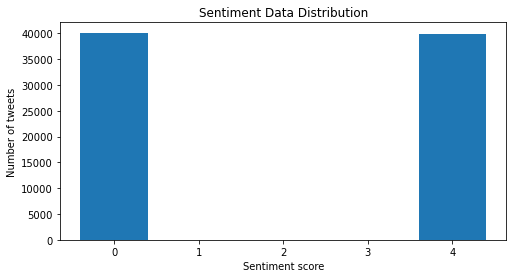

In [12]:
# balanced class: 0 for negative; 4 for positive
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.title("Sentiment Data Distribution")

In [13]:
EMBEDDING_DIM = 400
BATCH_SIZE = 1024
EPOCHS = 10
MAX_SEQUENCE_LENGTH = 30

In [14]:
df['tweet'] = df['tweet'].astype('str')
train_df, test_v_df = train_test_split(df, test_size=0.2, random_state=0)
test_df, val_df = train_test_split(test_v_df, test_size=0.1, random_state=0)

Text(0.5, 1.0, 'Sentiment Data Distribution for train-test-val')

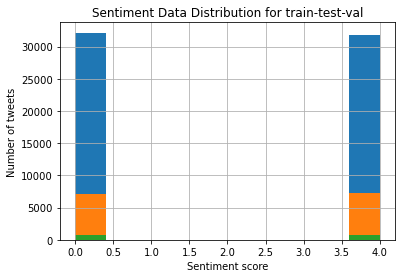

In [15]:
train_df.sentiment.hist(), test_df.sentiment.hist(), val_df.sentiment.hist()
plt.xlabel("Sentiment score")
plt.ylabel("Number of tweets")
plt.title("Sentiment Data Distribution for train-test-val")

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.tweet)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 66781


In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_df.tweet),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_df.tweet),
                       maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(tokenizer.texts_to_sequences(val_df.tweet),
                       maxlen = MAX_SEQUENCE_LENGTH)

x_val_only_words = pad_sequences(tokenizer.texts_to_sequences(val_df.only_words),
                       maxlen = MAX_SEQUENCE_LENGTH)
print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)

Training X Shape: (64000, 30)
Testing X Shape: (14400, 30)


### Label Encoding 

In [18]:
encoder = LabelEncoder()
encoder.fit(train_df.sentiment.to_list())

y_train = encoder.transform(train_df.sentiment.to_list())
y_test = encoder.transform(test_df.sentiment.to_list())
y_val = encoder.transform(val_df.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

y_train shape: (64000, 1)
y_test shape: (14400, 1)
y_val shape: (1600, 1)


In [19]:
# read fasttext twitter embeddings
embeddings_df = pd.read_pickle(data_dir + 'twitter_derived_embeddings')
embeddings_df.head()

,Token,Embeddings
0,aa,"[0.06992905, -0.6443515, 0.32829714, -0.420536..."
1,aaaa,"[-0.29368854, -0.28680354, 0.082138516, -0.093..."
2,aaaaaaallll,"[0.21100129, -0.24272849, -0.15285794, -0.2225..."
3,aaaaaand,"[0.15002657, 0.121883154, -0.13981317, 0.04672..."
4,aaarrrgghhh,"[0.23939471, -0.120745406, -0.023043174, -0.16..."


In [20]:
fasttext_embedding_idx = {}
for idx, row in embeddings_df.iterrows():
    word = row[0]
    embeddings = np.asarray(row[1], 'float32')
    fasttext_embedding_idx[word] = embeddings

# print only 20
fasttext_embedding_idx['earthquake'][:20]

array([ 0.36360028,  0.06347924, -0.20796725, -0.1053633 , -0.4619699 ,
       -0.5379099 , -0.24516329, -0.373171  ,  0.55195075, -0.0964388 ,
       -0.02738901, -0.68742454,  0.04655449,  0.31652683, -0.28420547,
        0.32772318, -0.48024014, -0.5669692 ,  0.5986041 , -0.4811064 ],
      dtype=float32)

In [21]:
embeddings_index = fasttext_embedding_idx
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
embedding_layer = Embedding(vocab_size,
                          EMBEDDING_DIM,
                          weights=[embedding_matrix],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-06-11 11:17:49.187285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 400)           26712400  
                                                                 
 dropout (Dropout)           (None, 30, 400)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               200400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 26,912,901
Trainable params: 200,501
Non-trainable params: 26,712,400
_________________________________________________________________


In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_with_punc = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test))

Epoch 1/10
63/63 [==============================] - 43s 629ms/step - loss: 0.0698 - accuracy: 0.9848 - val_loss: 6.6350e-04 - val_accuracy: 0.9999
Epoch 2/10
63/63 [==============================] - 37s 580ms/step - loss: 7.8908e-04 - accuracy: 0.9999 - val_loss: 4.0090e-04 - val_accuracy: 0.9999
Epoch 3/10
63/63 [==============================] - 35s 558ms/step - loss: 5.4582e-04 - accuracy: 0.9999 - val_loss: 3.0667e-04 - val_accuracy: 0.9999
Epoch 4/10
63/63 [==============================] - 38s 598ms/step - loss: 3.6474e-04 - accuracy: 1.0000 - val_loss: 2.6503e-04 - val_accuracy: 0.9999
Epoch 5/10
63/63 [==============================] - 37s 593ms/step - loss: 3.7468e-04 - accuracy: 0.9999 - val_loss: 2.7485e-04 - val_accuracy: 0.9999
Epoch 6/10
63/63 [==============================] - 40s 629ms/step - loss: 3.4200e-04 - accuracy: 0.9999 - val_loss: 2.2341e-04 - val_accuracy: 0.9999
Epoch 7/10
63/63 [==============================] - 37s 588ms/step - loss: 3.2706e-04 - accuracy: 

### Model Evaluation

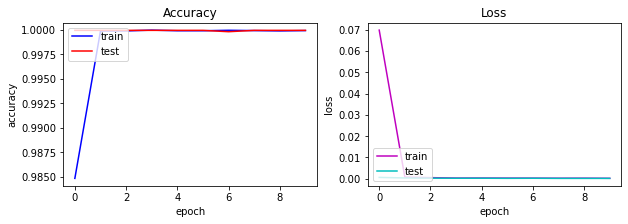

In [24]:
history = history_with_punc
s, (at, al) = plt.subplots(1,2, figsize=(10, 3))
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('Accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['train', 'test'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('Loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'test'], loc = 'lower left')

In [34]:
def decode_sentiment(score):
    return 4 if score>0.5 else 0

# make predictions on trained pattern and unseen pattern
scores = model.predict(x_val, verbose=1, batch_size=16)
scores_only_words = model.predict(x_val_only_words, verbose=1, batch_size=16)
y_pred = [decode_sentiment(score) for score in scores]
y_pred_only_words = [decode_sentiment(score) for score in scores_only_words]

100/100 [==============================] - 1s 10ms/step


### Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [28]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ['negative', 'positive'], fontsize=13)
    plt.yticks(tick_marks, ['negative', 'positive'], fontsize=13, rotation = 90)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)

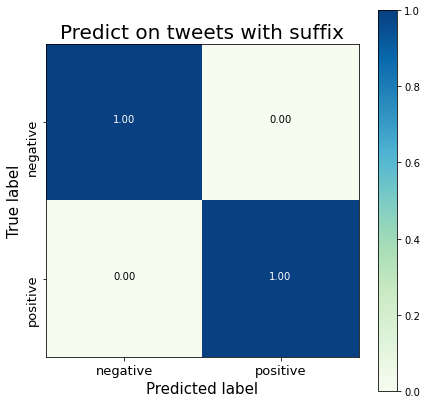

In [38]:
cnf_matrix1 = confusion_matrix(val_df.sentiment.to_list(), y_pred)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix1, classes=val_df.sentiment.unique(), title="Predict on tweets with suffix")
plt.savefig("figures/withsuffix.png")

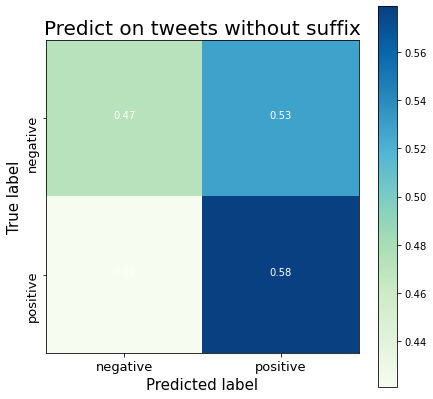

In [37]:
cnf_matrix2 = confusion_matrix(val_df.sentiment.to_list(), y_pred_only_words)
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix2, classes=val_df.sentiment.unique(), title="Predict on tweets without suffix")
plt.savefig("figures/nosuffix.png")

### Classification Scores

In [39]:
print(classification_report(list(val_df.sentiment), y_pred))
print(classification_report(list(val_df.sentiment), y_pred_only_words))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       807
           4       1.00      1.00      1.00       793

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

              precision    recall  f1-score   support

           0       0.53      0.47      0.50       807
           4       0.52      0.58      0.55       793

    accuracy                           0.53      1600
   macro avg       0.53      0.53      0.52      1600
weighted avg       0.53      0.53      0.52      1600

